<a href="https://colab.research.google.com/github/anshupandey/Computer-Vision/blob/master/object%20detection/Object_detection_Colab_YOLOv9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Notebook YOLOv9

Implementation of paper - [YOLOv9: Learning What You Want to Learn Using Programmable Gradient Information](https://arxiv.org/abs/2402.13616)

This Colab Notebook is a demo version of the [Yolov9 model](https://github.com/WongKinYiu/yolov9).

<div align="center">
    <a href="./">
        <img src="https://huggingface.co/adonaivera/yolov9/resolve/main/performance.png" width="79%"/>
    </a>
</div>


## Performance

MS COCO

| Model | Test Size | AP<sup>val</sup> | AP<sub>50</sub><sup>val</sup> | AP<sub>75</sub><sup>val</sup> | Param. | FLOPs |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| [**YOLOv9-S**]() | 640 | **46.8%** | **63.4%** | **50.7%** | **7.2M** | **26.7G** |
| [**YOLOv9-M**]() | 640 | **51.4%** | **68.1%** | **56.1%** | **20.1M** | **76.8G** |
| [**YOLOv9-C**](https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt) | 640 | **53.0%** | **70.2%** | **57.8%** | **25.5M** | **102.8G** |
| [**YOLOv9-E**](https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt) | 640 | **55.6%** | **72.8%** | **60.6%** | **58.1M** | **192.5G** |


## Install Packages

In [1]:
!git clone --recursive https://github.com/WongKinYiu/yolov9.git
%cd yolov9/

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/yolov9


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content/yolov9


In [3]:
!pip install -r requirements.txt -q
!pip install supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.3 MB/s eta 0:00:00


## Load example Images and Models

In [4]:
!wget -P {HOME} -q https://storage.googleapis.com/adonaivera_certified/test.jpeg

In [5]:
!mkdir -p {HOME}/weights

In [6]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

## Inference with pre-trained models in Images with YoloV9 and Supervision

In [7]:
import torch
import cv2
import numpy as np
from models.common import DetectMultiBackend
from utils.general import non_max_suppression, scale_boxes
from utils.torch_utils import select_device, smart_inference_mode
from utils.augmentations import letterbox
import PIL.Image
import supervision as sv

@smart_inference_mode()
def predict(image_path, weights='yolov9-c.pt', imgsz=640, conf_thres=0.1, iou_thres=0.45, device='0', data='data/coco.yaml'):
    # Initialize
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, fp16=False, data=data)
    stride, names, pt = model.stride, model.names, model.pt

    # Load image
    image = PIL.Image.open(image_path)
    img0 = np.array(image)
    assert img0 is not None, f'Image Not Found {image_path}'
    img = letterbox(img0, imgsz, stride=stride, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Init bounding box annotator and label annotator
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

    # Inference
    pred = model(img, augment=False, visualize=False)

    # Apply NMS
    pred = non_max_suppression(pred[0][0], conf_thres, iou_thres, classes=None, max_det=1000)

    # Process detections
    for i, det in enumerate(pred):
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in reversed(det):
                label = f'{names[int(cls)]} {conf:.2f}'
                # Transform detections to supervisions detections
                detections = sv.Detections(
                    xyxy=torch.stack(xyxy).cpu().numpy().reshape(1, -1),
                    class_id=np.array([int(cls)]),
                    confidence=np.array([float(conf)])
                )

                # Labels
                labels = [
                    f"{class_id} {confidence:0.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]

                img0 = bounding_box_annotator.annotate(img0, detections)
                img0 = label_annotator.annotate(img0, detections, labels)

    return img0[:, :, ::-1]


If you want to test your own image or try another YoloV9 model, modify the image_path or the weights

In [8]:
%matplotlib inline

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


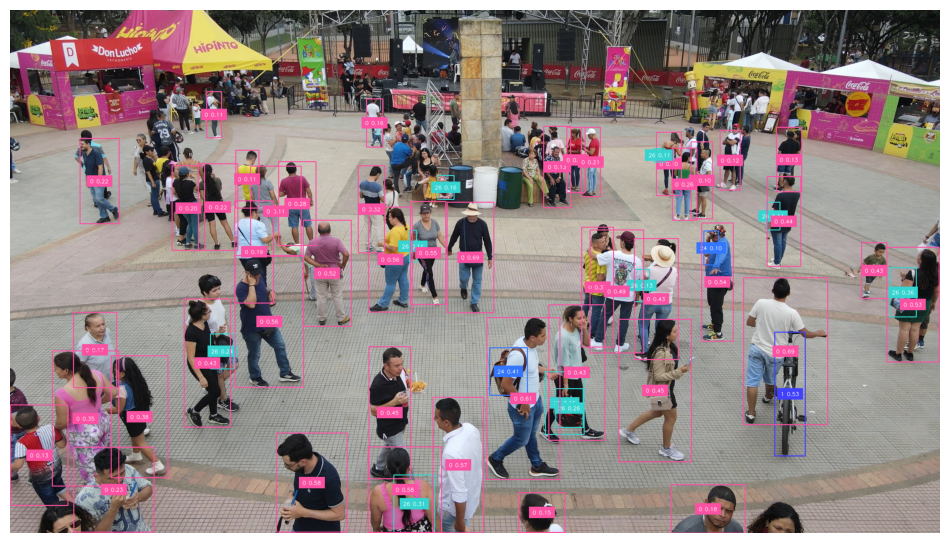

In [9]:
img = predict(image_path=f'{HOME}/test.jpeg',weights=f'{HOME}/weights/yolov9-e.pt')
sv.plot_image(img)


## Citation

```
@article{wang2024yolov9,
  title={{YOLOv9}: Learning What You Want to Learn Using Programmable Gradient Information},
  author={Wang, Chien-Yao  and Liao, Hong-Yuan Mark},
  booktitle={arXiv preprint arXiv:2402.13616},
  year={2024}
}
```


## Contributor Google Colab

Author Yolo V9: Wang, Chien-Yao  and Liao, Hong-Yuan Mark. [YoloV9 GitHub](https://github.com/WongKinYiu/yolov9) 🚀


Who created the Google Colab demo: [AdonaiVera's GitHub](https://github.com/AdonaiVera) 👋